In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from collections import Counter
from torch.optim import Adam
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from tqdm import tqdm

## Dataset

In [2]:
my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class AffineTransform:
    def __init__(self, rotation_range, scale_range, translate_range):
        self.rotation_range = rotation_range
        self.scale_range = scale_range
        self.translate_range = translate_range

    def __call__(self, img):
        angle = random.uniform(-self.rotation_range, self.rotation_range)
        scale = random.uniform(self.scale_range[0], self.scale_range[1])
        translate_x = random.uniform(self.translate_range[0], self.translate_range[1])
        translate_y = random.uniform(self.translate_range[0], self.translate_range[1])

        transformation = transforms.Compose([
            transforms.RandomAffine(
                degrees=0,
                translate=(translate_x / img.size[0], translate_y / img.size[1]),
                scale=(scale, scale),
                shear=0,
            ),
            transforms.RandomRotation(degrees=self.rotation_range),
        ])
        
        return transformation(img)

class AffineMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(AffineMNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.affine_transform = AffineTransform(rotation_range=30, scale_range=(0.5, 1.0), translate_range=(0, 5))

    def __getitem__(self, index):
        img, target = super(AffineMNIST, self).__getitem__(index)
        img = self.affine_transform(img)
        img = my_transform(img)
        return img, target


seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=my_transform)
test_dataset = AffineMNIST(root='./data', train=False, transform=None, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.23MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 14.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 43.0MB/s]


Extracting ./data/AffineMNIST/raw/train-images-idx3-ubyte.gz to ./data/AffineMNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]


Extracting ./data/AffineMNIST/raw/train-labels-idx1-ubyte.gz to ./data/AffineMNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/AffineMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/AffineMNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]

Extracting ./data/AffineMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/AffineMNIST/raw



In [3]:
digit_counter = Counter()
for images, labels in train_loader:
    digit_counter.update(labels.numpy())
for digit, count in digit_counter.items():
    print(f"Digit {digit}: {count}")

print('--------')

digit_counter = Counter()
for images, labels in test_loader:
    digit_counter.update(labels.numpy())
for digit, count in digit_counter.items():
    print(f"Digit {digit}: {count}")

Digit 1: 6742
Digit 2: 5958
Digit 8: 5851
Digit 5: 5421
Digit 6: 5918
Digit 9: 5949
Digit 4: 5842
Digit 0: 5923
Digit 3: 6131
Digit 7: 6265
--------
Digit 3: 1010
Digit 0: 980
Digit 2: 1032
Digit 8: 974
Digit 4: 982
Digit 7: 1028
Digit 1: 1135
Digit 9: 1009
Digit 6: 958
Digit 5: 892


## Capsule

In [4]:
def debug_print(debug, message, tensor=None):
    if debug:
        if tensor is not None:
            print(f"{message}: {tensor.shape}")
        else:
            print(message)

def squash(input_tensor, epsilon=1e-7):
    squared_norm = (input_tensor ** 2 + epsilon).sum(-1, keepdim=True)
    output_tensor = (squared_norm / (1. + squared_norm)) *  (input_tensor / torch.sqrt(squared_norm))
    return output_tensor

class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=256, kernel_size=9, debug=False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1)
        self.debug = debug

    def forward(self, x):
        x = self.conv(x)
        debug_print(self.debug, "x after conv", x)
        x = F.relu(x)
        debug_print(self.debug, "x after ReLU", x)
        return x


class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9, debug=False):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList()
        for _ in range(num_capsules):
            capsule = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0)
            self.capsules.append(capsule)
        self.debug = debug
    
    def forward(self, x):
        stacked_capsules = [capsule(x) for capsule in self.capsules]
        if self.debug: 
            print("capsule_out:")
            for capsule_out in stacked_capsules:
                print("\t", capsule_out.shape)
        stacked_capsules = torch.stack(stacked_capsules, dim=1)
        debug_print(self.debug, "stacked_capsules", stacked_capsules)
        flattened_capsules = stacked_capsules.view(x.size(0), 32 * 6 * 6, -1)
        debug_print(self.debug, "flattened_capsules", flattened_capsules)
        squashed_output = squash(flattened_capsules)
        debug_print(self.debug, "squashed_output", squashed_output)
        return squashed_output


class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16, debug=False):
        super(DigitCaps, self).__init__()
        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))
        self.debug = debug

    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        debug_print(self.debug, "x after stacking", x)

        W = torch.cat([self.W] * batch_size, dim=0)
        debug_print(self.debug, "W", W)
        
        u_hat = torch.matmul(W, x)
        debug_print(self.debug, "u_hat", u_hat)

        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        b_ij = b_ij.to(device)
        debug_print(self.debug, "b_ij", b_ij)

        num_iter = 3
        for i in range(num_iter):
            if self.debug: print()
            c_ij = F.softmax(b_ij, dim=1)
            debug_print(self.debug, "c_ij", c_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)
            debug_print(self.debug, "c_ij after repeat", c_ij)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            debug_print(self.debug, "s_j", s_j)

            v_j = squash(s_j)
            debug_print(self.debug, "v_j", v_j)
            
            a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
            debug_print(self.debug, "a_ij", a_ij)
            b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)
            debug_print(self.debug, "b_ij updated", b_ij)

        return v_j.squeeze(1)

class Decoder(nn.Module):
    def __init__(self, debug=False):
        super(Decoder, self).__init__()
        self.debug = debug
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        debug_print(self.debug, "classes before softmax", classes)
        classes = F.softmax(classes, dim=0)
        debug_print(self.debug, "classes after softmax", classes)
        
        _, max_length_indices = classes.max(dim=1)
        debug_print(self.debug, "max_length_indices", max_length_indices)
        masked = Variable(torch.sparse.torch.eye(10))
        debug_print(self.debug, "masked", masked)
        masked = masked.to(device)
        masked = masked.index_select(dim=0, index=Variable(max_length_indices.squeeze(1).data))
        debug_print(self.debug, "masked after index_select", masked)
        
        return masked


In [5]:
class CapsuleNet(nn.Module):
    def __init__(self, debug=False):
        super(CapsuleNet, self).__init__()
        self.conv_layer = ConvLayer(debug=debug)
        self.primary_capsules = PrimaryCaps(debug=debug)
        self.digit_capsules = DigitCaps(debug=debug)
        self.decoder = Decoder(debug=debug)
        self.mse_loss = nn.MSELoss()
        self.debug = debug
        
    def forward(self, data):
        debug_print(self.debug, f"Input data", data)
        debug_print(self.debug, "\nCONV")
        output = self.conv_layer(data)
        debug_print(self.debug, "\nPRIMARY")
        output = self.primary_capsules(output)
        debug_print(self.debug, "\nDIGIT")
        output = self.digit_capsules(output)
        debug_print(self.debug, "\nDECODER")
        masked = self.decoder(output, data)
        debug_print(self.debug, "\nOUTPUT", output)
        return output, masked

    def loss(self, x, target):
        return self.margin_loss(x, target)
    
    def margin_loss(self, x, labels):
        batch_size = x.size(0)
        v_k = torch.sqrt((x**2).sum(dim=2, keepdim=True))
        left = F.relu(0.9 - v_k).view(batch_size, -1)
        right = F.relu(v_k - 0.1).view(batch_size, -1)
        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()
        return loss

In [8]:
capsule_net = CapsuleNet().to(device) 
optimizer = Adam(capsule_net.parameters())

n_epochs = 20

for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, masked = capsule_net(data)
        loss = capsule_net.loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = np.argmax(masked.data.cpu().numpy(), axis=1)
        targets = np.argmax(target.data.cpu().numpy(), axis=1)
        correct_train += np.sum(preds == targets)
        total_train += len(targets)
    
    train_accuracy = correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_accuracy:.4f}")
    

100%|██████████| 469/469 [02:36<00:00,  2.99it/s]


Epoch 1/20 - Loss: 0.2709 - Accuracy: 0.9294


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 2/20 - Loss: 0.0599 - Accuracy: 0.9795


100%|██████████| 469/469 [02:36<00:00,  2.99it/s]


Epoch 3/20 - Loss: 0.0429 - Accuracy: 0.9856


100%|██████████| 469/469 [02:36<00:00,  2.99it/s]


Epoch 4/20 - Loss: 0.0350 - Accuracy: 0.9884


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 5/20 - Loss: 0.0300 - Accuracy: 0.9898


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 6/20 - Loss: 0.0267 - Accuracy: 0.9914


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 7/20 - Loss: 0.0241 - Accuracy: 0.9927


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 8/20 - Loss: 0.0215 - Accuracy: 0.9931


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 9/20 - Loss: 0.0198 - Accuracy: 0.9942


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 10/20 - Loss: 0.0182 - Accuracy: 0.9947


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 11/20 - Loss: 0.0167 - Accuracy: 0.9953


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 12/20 - Loss: 0.0153 - Accuracy: 0.9958


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 13/20 - Loss: 0.0136 - Accuracy: 0.9963


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 14/20 - Loss: 0.0135 - Accuracy: 0.9967


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 15/20 - Loss: 0.0121 - Accuracy: 0.9970


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 16/20 - Loss: 0.0107 - Accuracy: 0.9972


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 17/20 - Loss: 0.0100 - Accuracy: 0.9976


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 18/20 - Loss: 0.0089 - Accuracy: 0.9978


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]


Epoch 19/20 - Loss: 0.0084 - Accuracy: 0.9982


100%|██████████| 469/469 [02:36<00:00,  3.00it/s]

Epoch 20/20 - Loss: 0.0083 - Accuracy: 0.9985


In [9]:
capsule_net.eval()
test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data, target in test_loader:
        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)

        output, masked = capsule_net(data)
        loss = capsule_net.loss(output, target)
        test_loss += loss.item()

        preds = np.argmax(masked.data.cpu().numpy(), axis=1)
        targets = np.argmax(target.data.cpu().numpy(), axis=1)
        correct_test += np.sum(preds == targets)
        total_test += len(targets)

test_accuracy = correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5326 - Test Accuracy: 0.6932


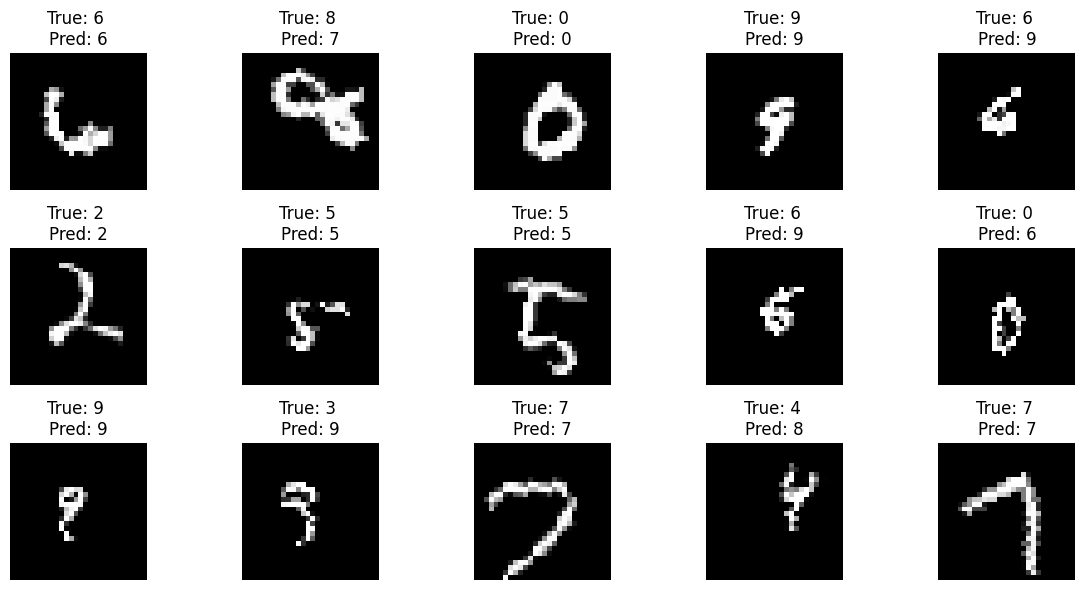

In [10]:
capsule_net.eval()

with torch.no_grad():
    data, target = next(iter(test_loader))
    target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
    data, target = Variable(data), Variable(target)
    data, target = data.to(device), target.to(device)
    output, masked = capsule_net(data)
    preds = np.argmax(masked.data.cpu().numpy(), axis=1)
    targets = np.argmax(target.data.cpu().numpy(), axis=1)

    fig, axes = plt.subplots(3, 5, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(15):
        ax = axes[i]
        ax.imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f"True: {targets[i]} \nPred: {preds[i]}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## CNN

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=9, stride=1)
        self.conv2 = nn.Conv2d(256, 32, kernel_size=9, stride=2, padding=0)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def loss(self, output, target):
        return F.cross_entropy(output, target)

In [36]:
cnn = CNN().to(device)
optimizer = Adam(cnn.parameters())

n_epochs = 20
for epoch in range(n_epochs):
    cnn.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_id, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = cnn(data)
        loss = cnn.loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = output.argmax(dim=1, keepdim=True)
        correct_train += preds.eq(target.view_as(preds)).sum().item()
        total_train += target.size(0)
    
    train_accuracy = correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_accuracy:.4f}")

100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 1/20 - Loss: 0.1980 - Accuracy: 0.9399


100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 2/20 - Loss: 0.0659 - Accuracy: 0.9797


100%|██████████| 469/469 [00:20<00:00, 22.56it/s]


Epoch 3/20 - Loss: 0.0490 - Accuracy: 0.9853


100%|██████████| 469/469 [00:20<00:00, 22.51it/s]


Epoch 4/20 - Loss: 0.0385 - Accuracy: 0.9884


100%|██████████| 469/469 [00:20<00:00, 22.49it/s]


Epoch 5/20 - Loss: 0.0305 - Accuracy: 0.9903


100%|██████████| 469/469 [00:20<00:00, 22.62it/s]


Epoch 6/20 - Loss: 0.0263 - Accuracy: 0.9918


100%|██████████| 469/469 [00:20<00:00, 22.57it/s]


Epoch 7/20 - Loss: 0.0241 - Accuracy: 0.9924


100%|██████████| 469/469 [00:20<00:00, 22.60it/s]


Epoch 8/20 - Loss: 0.0200 - Accuracy: 0.9934


100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Epoch 9/20 - Loss: 0.0159 - Accuracy: 0.9949


100%|██████████| 469/469 [00:20<00:00, 22.53it/s]


Epoch 10/20 - Loss: 0.0163 - Accuracy: 0.9948


100%|██████████| 469/469 [00:20<00:00, 22.65it/s]


Epoch 11/20 - Loss: 0.0126 - Accuracy: 0.9959


100%|██████████| 469/469 [00:20<00:00, 22.66it/s]


Epoch 12/20 - Loss: 0.0145 - Accuracy: 0.9953


100%|██████████| 469/469 [00:20<00:00, 22.45it/s]


Epoch 13/20 - Loss: 0.0093 - Accuracy: 0.9969


100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Epoch 14/20 - Loss: 0.0099 - Accuracy: 0.9971


100%|██████████| 469/469 [00:20<00:00, 22.60it/s]


Epoch 15/20 - Loss: 0.0143 - Accuracy: 0.9956


100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Epoch 16/20 - Loss: 0.0083 - Accuracy: 0.9971


100%|██████████| 469/469 [00:20<00:00, 22.54it/s]


Epoch 17/20 - Loss: 0.0077 - Accuracy: 0.9972


100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Epoch 18/20 - Loss: 0.0076 - Accuracy: 0.9976


100%|██████████| 469/469 [00:20<00:00, 22.61it/s]


Epoch 19/20 - Loss: 0.0088 - Accuracy: 0.9972


100%|██████████| 469/469 [00:20<00:00, 22.69it/s]

Epoch 20/20 - Loss: 0.0101 - Accuracy: 0.9969


In [37]:
cnn.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = cnn(data)
        loss = cnn.loss(output, target)

        test_loss += loss.item()
        
        preds = output.argmax(dim=1, keepdim=True)
        correct_test += preds.eq(target.view_as(preds)).sum().item()
        total_test += target.size(0)

test_accuracy = correct_test / total_test
avg_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

Test Loss: 3.0234 - Test Accuracy: 0.5967
